# Аналитика стартапа по продаже продуктов питания

**Содержание:**
* [1. Исследование данных и их предобработка](#Исследование-данных-и-их-предобработка)
 * [1.1 Загрузка данных и извлечение информации](#)
 * [1.2 Промежуточный вывод](#Промежуточный-вывод)
* [2. Изучение и проверка данных](#Изучение-и-проверка-данных)
* [3. Изучение воронки событий](#Изучение-воронки-событий)
* [4. Исследование результатов эксперимента](#Исследование-результатов-эксперимента)
* [5. Вывод](#Вывод)

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения.  
Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?  
После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.  

Целью настоящего исследования является изучение поведения пользоваталей и анализ результатов А/А/В-тестов.

**Полученные данные хранятся в файле:**  
`logs_exp.csv`

**Описание данных:**

Каждая запись в логе — это действие пользователя, или событие.  
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestam`p — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Исследование данных и их предобработка 

### Загрузка данных и извлечение информации

Начнем с импорта необходимых для работы библиотек

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
from scipy import stats as st
import math as mth
import warnings
warnings.simplefilter('ignore')

In [2]:
import plotly.io as pio
pio.renderers.default = "svg"

Импортируем предоставленныый файл и сохраним его в переменной df

In [3]:
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    df = pd.read_csv('logs_exp.csv', sep='\t')

Изучим данные в файле, выведем на экран первые 5 строк датафрейма, общую информацию, информацию о доли пропущенных значений и колчестве явных дубликатов:

In [4]:
print('Внешний вид датафрейма:')
display(df.head(5))
print('``````````````````````````````````````````````````')
print('Типы данных, кол-во строк и столбцов:')
print(df.info())
print('``````````````````````````````````````````````````')
print('Доля пропущенных значений:')    
print(df.isnull().mean())
print('``````````````````````````````````````````````````')
print('Количество явных дубликатов:')
print(round(df.duplicated().sum()/len(df)*100,2), '%')
print('``````````````````````````````````````````````````')

Внешний вид датафрейма:


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


``````````````````````````````````````````````````
Типы данных, кол-во строк и столбцов:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
``````````````````````````````````````````````````
Доля пропущенных значений:
EventName         0.0
DeviceIDHash      0.0
EventTimestamp    0.0
ExpId             0.0
dtype: float64
``````````````````````````````````````````````````
Количество явных дубликатов:
0.17 %
``````````````````````````````````````````````````


Изменим названия колонок на привычный нам змеиный регистр:

In [5]:
df = df.rename(columns = {'EventName' : 'event_name', 
                         'DeviceIDHash' : 'device_id_hash',
                         'EventTimestamp' : 'event_timestamp',
                         'ExpId' : 'exp_id'})
display(df.head(5))

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Теперь удалим дубликаты:

In [6]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Данные в колонке event_timestamp скорее всего хранятся в типе данных unix timestamp, создадим отделькые колонки date_time и date,  которые понадобятся нам в нашем исследовании, и приведем данные к виду, понятные простому пользователю:

In [7]:
df['date_time'] = pd.to_datetime(df['event_timestamp'],unit='s')
df['date'] = df['date_time'].dt.floor("D")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   date_time        243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


In [9]:
display(df.head(5))

,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Посмотрим, какие данные у нас в колонке event_time, нет ли там неявных дубликатов, если нет, то можно перейти к следующему разделу нашего исследования:

In [10]:
df['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

### Промежуточный вывод

Мы обработали входные данные, привели все названия к нижнему регистру, избавились от явных дубликатов, добавили колонки с датой и временем, а также проверили названия событий на наличие неявных дубликатов.

## Изучение и проверка данных

Теперь изучим данные, в полученном датафрейме.  

Посмотрим и посчитаем количество событий в колонке `event_name`:

In [11]:
b = df['event_name'].unique()
a = len(df['event_name'].unique())
c = len(df['event_name'])
print(f'Всего {a} названий событий, которые назваются: {b}')

print(f'Всего в датафрейме - {c} событий')


Всего 5 названий событий, которые назваются: ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']
Всего в датафрейме - 243713 событий


Посмотрим сколько всего пользователей в полученном логе событий:

In [12]:
len(df['device_id_hash'].unique())

7551

Получим информацию о том, сколько в среднем приходится событий на одного уникального пользователия:

In [13]:
round(len(df['event_timestamp'])/len(df['device_id_hash'].unique()))

32

Проверим -  данными за какой период мы располагаем? Найдем максимальную и минимальную дату и узнаем сколько дней длилось тестирование. Построим гистограмму по дате и времени и изучим их.

In [14]:
min_date = min(df['date'])
max_date = max(df['date'])
print(f'Минимальная дата {min_date}')
print(f'Максимальная дата {max_date}')

Минимальная дата 2019-07-25 00:00:00
Максимальная дата 2019-08-07 00:00:00


In [15]:
print(max_date-min_date)

13 days 00:00:00


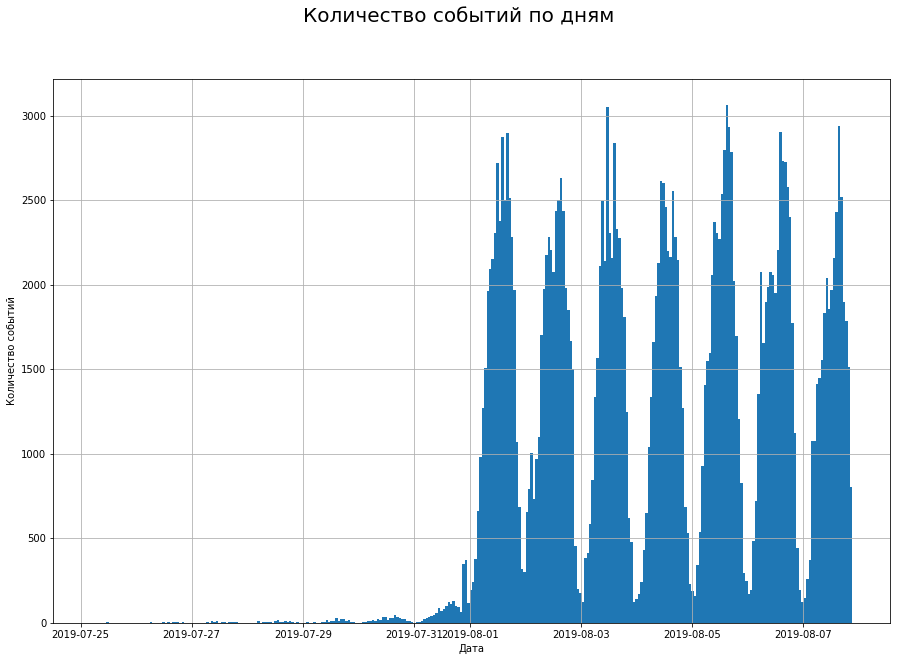

In [16]:
ax = df['date_time'].hist(figsize = (15,10), bins=(13*24));
plt.suptitle('Количество событий по дням', fontsize = 20);
ax.set_xlabel('Дата')
ax.set_ylabel('Количество событий');

Судя по построенному графику, можно предположить, что технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». 
Наиболее полные данные начинаются с 1 августа, поэтому посмотрим, сколько у нас событий, которые произошли до этой даты.

In [17]:
print(f"Количество записей до 1 августа составляет:\
      {round(len(df[df['date'] < '2019-08-01'])/len(df)*100,2)} %")

Количество записей до 1 августа составляет:      1.16 %


In [18]:
a = len(df[df['date'] < '2019-08-01']['device_id_hash'].unique())
b = a/(len(df))*100
print(f'Количество пользователей, который попадают в эти 1.16% составляет {round(b,2)} % от всех пользователей'
    )

Количество пользователей, который попадают в эти 1.16% составляет 0.6 % от всех пользователей


Всего 1.16% записей, которые искажают график, удалим их, чтобы не мешали дальнейшему исследованию и зададим новые значения миннимальной и максимальной дат.

In [19]:
df = df.query('date >= "2019-08-01"')
min_date = min(df['date_time'])
max_date = max(df['date_time'])
print(f'Минимальная дата {min_date}')
print(f'Максимальная дата {max_date}')

Минимальная дата 2019-08-01 00:07:28
Максимальная дата 2019-08-07 21:15:17


Теперь у нас развернутые данные за период одной недели - с 1 августа по 7 августа.

Проверим, есть ли пользователи в каждой из трех групп теста, не получилось ли так, что в какой-то группе никого нет.

In [20]:
df.head(5)

,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [21]:
df.pivot_table(index='exp_id', values='device_id_hash', aggfunc=('count', 'nunique'))

,count,nunique
exp_id,,
246,79302,2484
247,77022,2513
248,84563,2537


Пользователи есть в каждой из 3-х групп, в двух контрольных и одной экспериментальной.

## Изучение воронки событий

Посмотрим, какие события есть в логах, как часто они встречаются: 

In [22]:
events = df.pivot_table(index='event_name', values='device_id_hash', aggfunc='count')\
         .sort_values(by='device_id_hash', ascending=False)\
         .reset_index()
display(events)

,event_name,device_id_hash
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Теперь посчитаем сколько пользователей совершали события и какова доля пользователей, которые хоть раз совершали то или иное событие:

In [23]:
df.head()

,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [24]:
events_users = df.pivot_table(index='event_name', values='device_id_hash', aggfunc=('count', 'nunique'))\
               .sort_values(by='nunique', ascending=False)\
               .reset_index()
events_users['percentage'] = round((events_users['nunique']/len(df['device_id_hash'].unique())*100), 2)
display(events_users)

,event_name,count,nunique,percentage
0,MainScreenAppear,117328,7419,98.47
1,OffersScreenAppear,46333,4593,60.96
2,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97
4,Tutorial,1005,840,11.15


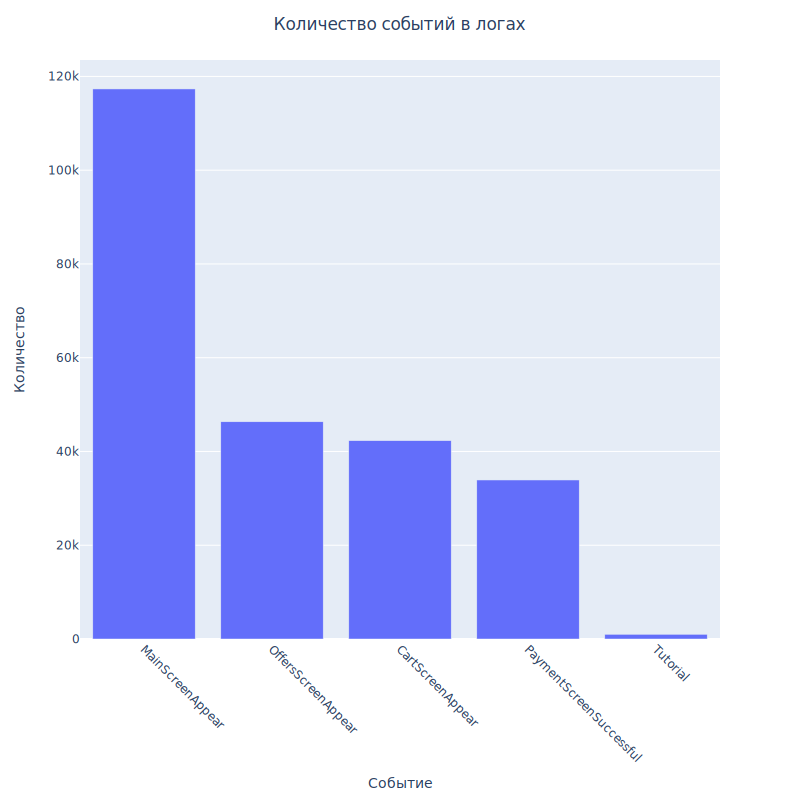

In [25]:
fig = px.bar(
    events, x='event_name', y='device_id_hash', 
    labels=dict({'event_name': 'Событие', 'device_id_hash':'Количество'}),
    width=800, height=800
)
fig.update_xaxes(tickangle=45)
fig.update_layout(title_text='Количество событий в логах', title_x=0.5, 
                 )
fig.show() 

По получившимся данным можно сказать следующее: 
Мы определили порядок в воронке событий в наших данных, а именно:
- **MainScreenAppear** - показ главного экрана
- **OffersScreenAppear** - показ страницы с предложением
- **CartScreenAppear** - показ страницы корзины
- **PaymentScreenSuccessful** - показ страницы с подтвержденной оплатой
- **Tutorial** - страница с инструкцией

На страницу с показом инструкции попадает наименьшее количество пользователей, вероятнее всего из-за того, что многие пользователи попросту ее пропускают, поэтому можно исключить эти данные из дальнейшего анализа, поскольку они никак не влияют в схеме наших логов на переход к странице оплаты.

Визуализируем воронку событий в правильном порядке и посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

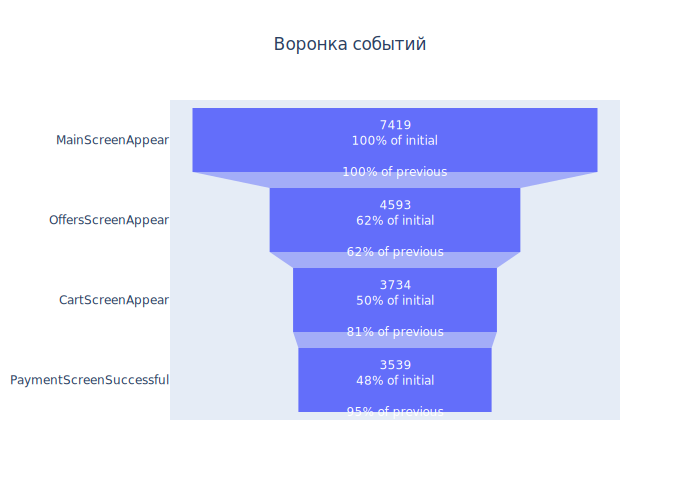

In [26]:
events_users = events_users.query('event_name != "Tutorial"')
fig = go.Figure(go.Funnel(x= events_users['nunique'], y=events_users['event_name'],
               textposition = "inside",
               textinfo = "value+percent previous+percent initial",)
               )
fig.update_layout(title_text='Воронка событий', title_x=0.5, 
                 )
fig.show()

По получившемуся графику мы видим, что от первого события(попадания на главный экран) до окна с оплатой доходят 48% пользователей, а больше всего пользователей теряется на шаге перехода с главного экрана на страницу с предложением - более 30%.  
После того, как пользователь попал на страницу с предложением, до оплаты доходит большая часть из них - 95%.

## Исследование результатов эксперимента

Проведем исследование результатов А/А/В теста, для начала еще раз посмотрим, сколько пользователей в каждой группе теста:

In [27]:
users_total = df.pivot_table(index='exp_id', values='device_id_hash', aggfunc='nunique')
users_total

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


Проверим, не попал ли кто-то из пользователей в две разные группы?

In [28]:
#Функция для сверки одинаковых пользователей в группах:
def dif_users(one, two):

    orders_a = df.query('exp_id == "one"')
    orders_b = df.query('exp_id == "two"')
    c = []
    for i in orders_a['device_id_hash'].unique():
        for j in orders_b['device_id_hash'].unique():
            if i == j:
                c.append(i)
                break
 
    print(f'Количество одинаковых пользователей в группах {one} и {two} = {len(c)}')

In [29]:
dif_users(246, 247)
dif_users(246, 248)
dif_users(247, 248)

Количество одинаковых пользователей в группах 246 и 247 = 0
Количество одинаковых пользователей в группах 246 и 248 = 0
Количество одинаковых пользователей в группах 247 и 248 = 0


Создадим функцию, которая будет принимать событие и считать число пользователей, совершивших это событие в каждой из контрольных групп. Потом она посчитает долю пользователей совершивших это событие. И проведет четыре проверки на то - является отличие между группами статистически достоверным - между группами А и В, А и С, В и С, и суммой контрольных А+В и С.  
Проверку будем проводить z-тестом Фишера на равенство долей.   

Зададим следующие Н0 и Н1 гипотезы:

* H0 - доли пользователей совершивших событие в сравниваемых группах одинаковы

* H1 - доли пользователей совершивших событие в сравниваемых группах отличаются 

* Критический уровень статистической значимости альфа - зададим равным 0.05 поделенным на 12, применяя поправку на множественную проверку гипотез Поправка Бонферрони

In [30]:
sample_A = df.query('exp_id == 246')
sample_B = df.query('exp_id == 247')
sample_C = df.query('exp_id == 248')

In [31]:
def func(name):
    global sample_A, sample_B, sample_C, users_total
    sample_AA = sample_A[sample_A['event_name'] == name]
    sample_BB = sample_B[sample_B['event_name'] == name]
    sample_CC = sample_C[sample_C['event_name'] == name]
    a = len((sample_AA["device_id_hash"].unique()))
    b = len((sample_BB["device_id_hash"].unique()))
    c = len((sample_CC["device_id_hash"].unique()))
    a_total = users_total['device_id_hash'].iloc[0]
    b_total = users_total['device_id_hash'].iloc[1]
    c_total = users_total['device_id_hash'].iloc[2]
    print(f'Количество пользователей в группе А, которые совершили событие {name} = {a}')
    print(f'Количество пользователей в группе B, которые совершили событие {name} = {b}')
    print(f'Количество пользователей в группе C, которые совершили событие {name} = {c}')
    print()
    print('-------------------------------------------------')
    print(f'Проведение z-тестов по событию {name}')
    
    alpha = 0.05/12  # критический уровень статистической значимости
    
    # пропорция в первой группе:
    p1 = a / a_total

    # пропорция во второй группе:
    p2 = b / b_total
    
    # пропорция в третьей группе:
    p3 = c / c_total
    
    print()
    print('-------------------------------------------------')
    print('Тест 1. Между группами А и В')    
    print('-------------------------------------------------')
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (a + b) / (a_total + b_total)
    
    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/a_total + 1/b_total))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2 

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
    print()    
    print('-------------------------------------------------')
    print('Тест 2. Между группами А и C')    
    print('-------------------------------------------------')

    # пропорция успехов в комбинированном датасете:
    p_combined = (a + c) / (a_total + c_total)
    
    # разница пропорций в датасетах
    difference = p1 - p3 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/a_total + 1/c_total))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
    print()    
    print('-------------------------------------------------')
    print('Тест 3. Между группами B и C')    
    print('-------------------------------------------------')

    # пропорция успехов в комбинированном датасете:
    p_combined = (b + c) / (b_total + c_total)
    
    # разница пропорций в датасетах
    difference = p2 - p3 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/b_total + 1/c_total))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2 

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
        
    print()    
    print('-------------------------------------------------')
    print('Тест 4. Между группами А+B и C')    
    print('-------------------------------------------------')

    # пропорция в первой группе:
    p1_sum = (a+b) / (a_total + b_total)

    # пропорция во второй группе:
    p3 = c / c_total
 
    # пропорция успехов в комбинированном датасете:
    p_combined = (a + b + c ) / (a_total + b_total + c_total)

    # разница пропорций в датасетах
    difference = p1_sum - p3 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * ((1/(a_total+b_total)) + 1/c_total))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(z_value)) * 2 

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )


И теперь применим получившуюся функцию к каждому из событий:

In [32]:
func('MainScreenAppear')

Количество пользователей в группе А, которые совершили событие MainScreenAppear = 2450
Количество пользователей в группе B, которые совершили событие MainScreenAppear = 2476
Количество пользователей в группе C, которые совершили событие MainScreenAppear = 2493

-------------------------------------------------
Проведение z-тестов по событию MainScreenAppear

-------------------------------------------------
Тест 1. Между группами А и В
-------------------------------------------------
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

-------------------------------------------------
Тест 2. Между группами А и C
-------------------------------------------------
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

-------------------------------------------------
Тест 3. Между группами B и C
-------------------------------------------------
p-значение:  0.458705361662151

In [33]:
func('OffersScreenAppear')

Количество пользователей в группе А, которые совершили событие OffersScreenAppear = 1542
Количество пользователей в группе B, которые совершили событие OffersScreenAppear = 1520
Количество пользователей в группе C, которые совершили событие OffersScreenAppear = 1531

-------------------------------------------------
Проведение z-тестов по событию OffersScreenAppear

-------------------------------------------------
Тест 1. Между группами А и В
-------------------------------------------------
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

-------------------------------------------------
Тест 2. Между группами А и C
-------------------------------------------------
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

-------------------------------------------------
Тест 3. Между группами B и C
-------------------------------------------------
p-значение:  0.919781

In [34]:
func('CartScreenAppear')

Количество пользователей в группе А, которые совершили событие CartScreenAppear = 1266
Количество пользователей в группе B, которые совершили событие CartScreenAppear = 1238
Количество пользователей в группе C, которые совершили событие CartScreenAppear = 1230

-------------------------------------------------
Проведение z-тестов по событию CartScreenAppear

-------------------------------------------------
Тест 1. Между группами А и В
-------------------------------------------------
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

-------------------------------------------------
Тест 2. Между группами А и C
-------------------------------------------------
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

-------------------------------------------------
Тест 3. Между группами B и C
-------------------------------------------------
p-значение:  0.5786197879539

In [35]:
func('PaymentScreenSuccessful')

Количество пользователей в группе А, которые совершили событие PaymentScreenSuccessful = 1200
Количество пользователей в группе B, которые совершили событие PaymentScreenSuccessful = 1158
Количество пользователей в группе C, которые совершили событие PaymentScreenSuccessful = 1181

-------------------------------------------------
Проведение z-тестов по событию PaymentScreenSuccessful

-------------------------------------------------
Тест 1. Между группами А и В
-------------------------------------------------
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

-------------------------------------------------
Тест 2. Между группами А и C
-------------------------------------------------
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

-------------------------------------------------
Тест 3. Между группами B и C
-------------------------------------------------
p

## Вывод

Мы провели большое исследование для стартапа, который продает продукты питания.  
В результате проделанной работы, мы привели полученные данные в порядок и избавились от дубликатов, изучили вороки событий в логах, и обнаружили, что от первого события(попадания на главный экран) до окна с оплатой доходят 48% пользователей, а больше всего пользователей теряется на шаге перехода с главного экрана на страницу с предложением - более 30%.  
После того, как пользователь попал на страницу с предложением, до оплаты доходит большая часть из них - 95%.
Страницу с инструкцией большинство пользователей попросту пропускают.  
Изучив данные о проведенном А/А/В-тестировании можно сделать следующий вывод:  
ни один z-test не показал значимые отличия в долях пользователей по всем группам, а это значит, что каких-либо изменений пользовательской активности от внедрения нового шрифта - нет.  
Принципиально, шрифт может быть изменен, но каких-либо приростов в количестве пользователей или в прибыли ожидать не стоит. 